# Lab: Explainability in Neural Networks with activation maximitation.


------------------------------------------------------
*Pablo M. Olmos pamartin@ing.uc3m.es*

------------------------------------------------------

In this part of the lab, we will implement a simple example of **activation maximization** to find out wich patterns are neccesary at the input of a neural network, that has been previously trained, to get a desired output (for example, a high confidence in a classification task).

We will visualize this technique using MNIST database.

PRÁCTICA 2. PARTE 3

DIEGO COLLADO MARTÍN - NIA: 100405606

DIEGO LÓPEZ LÓPEZ - NIA: 100507210


In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://i1.wp.com/datasmarts.net/es/wp-content/uploads/2019/09/1_yBdJCRwIJGoM7pwU-LNW6Q.png?w=479&ssl=1", width=400, height=200)

Load the dataset with torchvision ...

In [3]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.,), (1.0,)), # Media 0, varianza 1
                              ])

# Download and load the training  data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [4]:
dataiter = iter(trainloader)   # To iterate through the dataset

images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)


<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


Let's show some image from that batch ...

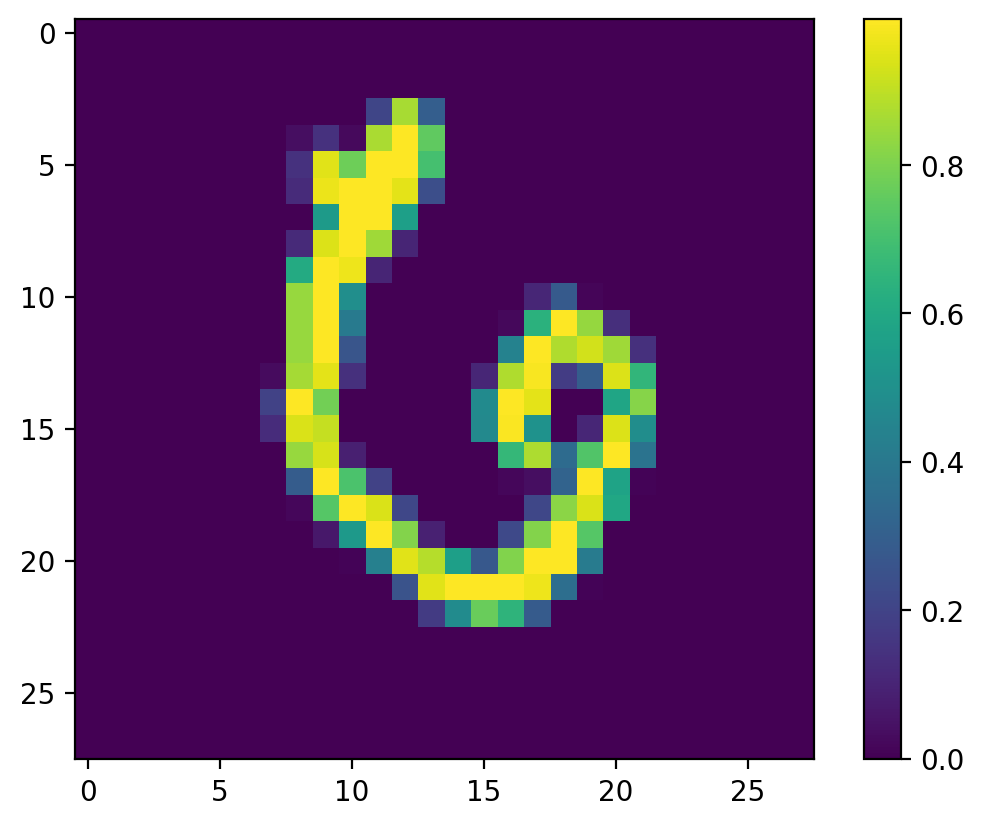

In [5]:
plt.imshow(images[1].numpy().reshape([28,28]), cmap='viridis')
plt.colorbar()

We also create a validation set.

In [6]:
import copy

validloader = copy.deepcopy(trainloader)  # Creates a copy of the object 

#We take the first 45k images for training
trainloader.dataset.data = trainloader.dataset.data[:45000,:,:]
trainloader.dataset.targets = trainloader.dataset.targets[:45000]

#And the rest for validation
validloader.dataset.data = validloader.dataset.data[45000:,:,:]
validloader.dataset.targets = validloader.dataset.targets[45000:]

> **Exercise:** Train an MLP network based on four dense layers of 256, 128, 64 and 10 hidden units respectively. Calculate the accuracy in training and test sets after training only 3 epochs. If you notice overfitting problems, introduce whatever mechanisms you consider to reduce it.

In [7]:
#YOUR CODE HERE

# Creamos un MLP con 3 capas ocultas y una salida con 10 neuronas (ya que tenemos 10 posibles clases)
# Entre capas aplicamos una ReLu (evitamos desvanecimiento de gradiente) y acabamos con una logsoftmax (para clasificación multiclase)

class MLP(nn.Module):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)                                                             
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.output2(x)
        x = self.relu(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [23]:
#YOUR CODE HERE

# Extendemos la clase para añadir el entrenamiento, el estudio del conjunto de validación y el análisis del accuracy

class MLP_extended(MLP):

    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        # Lista que guarda la evolución de la función de coste en validación a lo largo del entrenamiento

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0

            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad():
                for images_val, labels_val in validloader:

                    out_val = self.forward(images_val.view(images_val.shape[0], -1))
                    validation_loss += self.criterion(out_val, labels_val)
                    
                # De esta forma, en cada época, estudiamos el valor de la función de coste sobre todo el conjunto de validación

                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(validation_loss/len(validloader)) # Actualizamos dicho valor en la época correspondiente

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1])) # Mostramos el valor de la función de coste sobre el conjunto de valdación en cada época
                print('')

    def accuracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():

            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return ((accuracy/len(loader)).numpy())

In [24]:
# Definimos la red y la entrenamos

my_MLP = MLP_extended(dimx=784, hidden1=256, hidden2=128, hidden3=64, nlabels=10, epochs=3, lr=1e-3)
my_MLP.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.370293
Validation loss after 0 epochs: 0.174488

Training loss after 1 epochs: 0.135119
Validation loss after 1 epochs: 0.120015

Training loss after 2 epochs: 0.088342
Validation loss after 2 epochs: 0.124764



In [25]:
# Estudiamos los accuracy de los diferentes conjuntos de datos

accuracy_train_MLP = my_MLP.accuracy_study(trainloader,my_MLP)
accuracy_test_MLP = my_MLP.accuracy_study(testloader,my_MLP)
accuracy_val_MLP = my_MLP.accuracy_study(validloader,my_MLP)

print('El accuracy en el set de entrenamiento es: ' + str(accuracy_train_MLP))
print('El accuracy en el set de validación es: ' + str(accuracy_val_MLP))
print('El accuracy en el set de test es: ' + str(accuracy_test_MLP))

El accuracy en el set de entrenamiento es: 0.97589666
El accuracy en el set de validación es: 0.9625886
El accuracy en el set de test es: 0.9631767


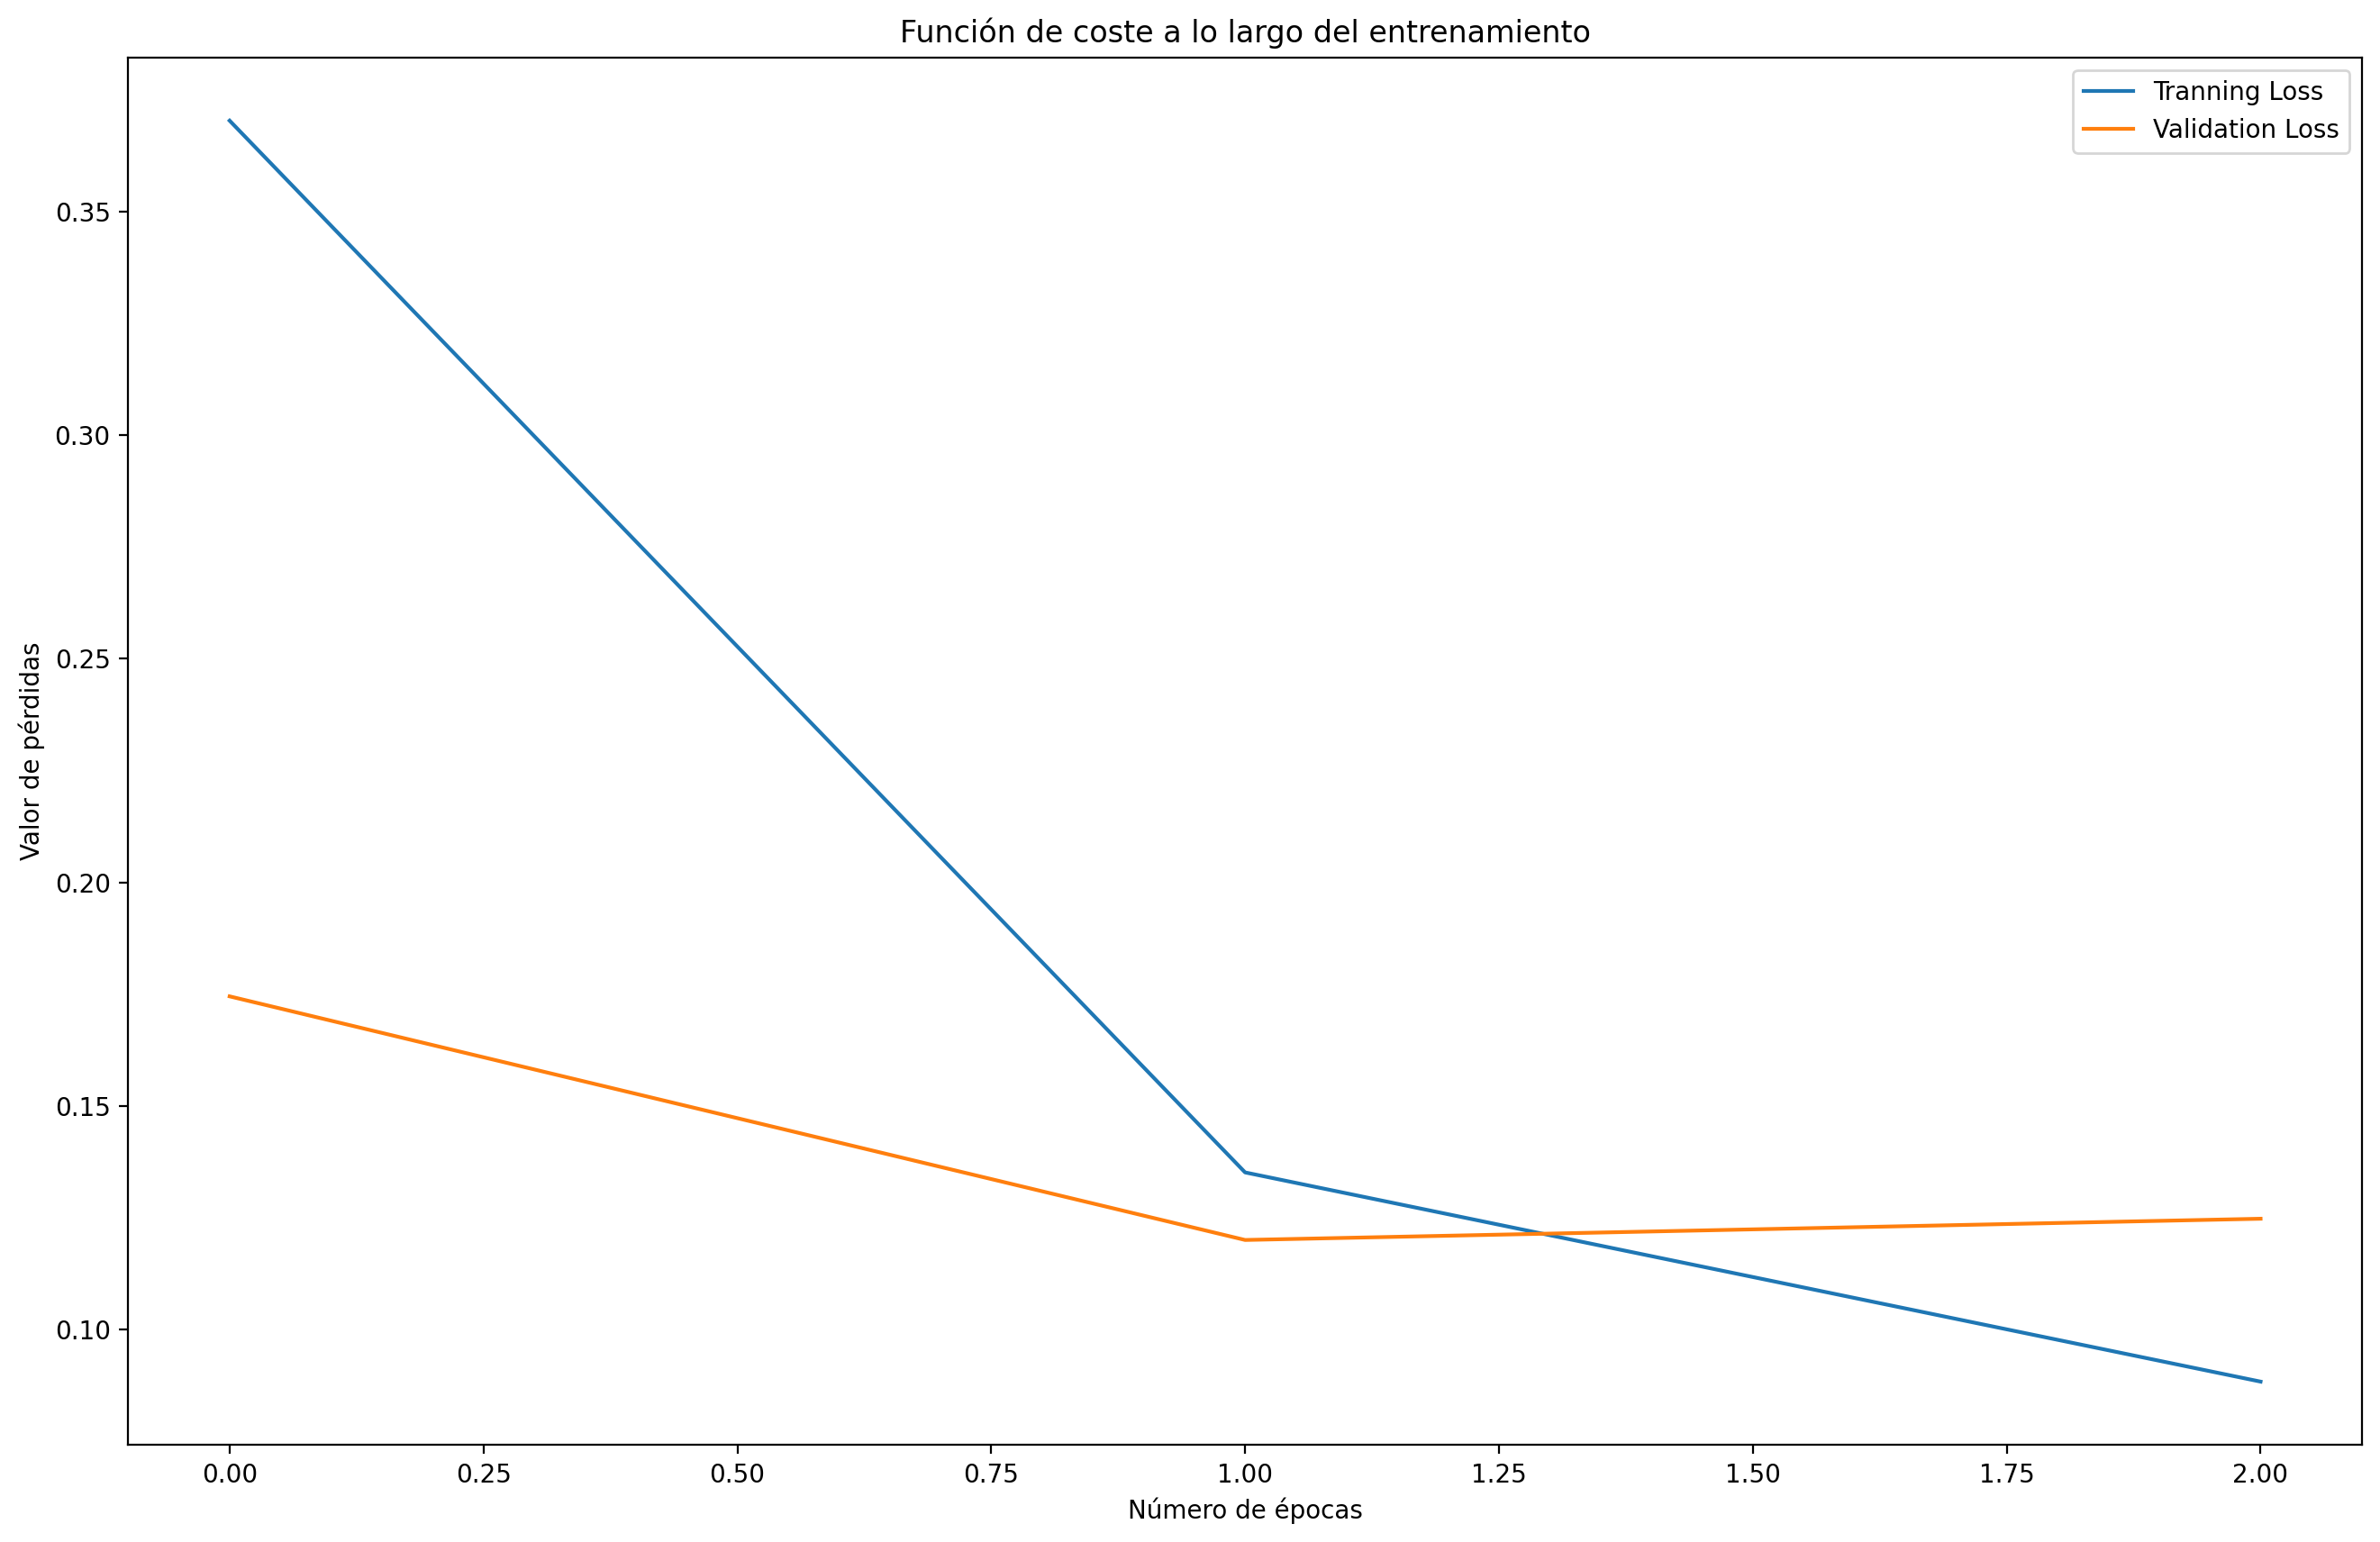

In [27]:
# Analizamos la función de coste de entrenamiento y de validación

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(my_MLP.loss_during_training,label='Tranning Loss')
ax.plot(my_MLP.valid_loss_during_training,label='Validation Loss')
ax.set_title('Función de coste a lo largo del entrenamiento')
ax.set_xlabel('Número de épocas')
ax.set_ylabel('Valor de pérdidas')
ax.legend()

Podemos observar que mientras que la función de coste para el conjunto de entrenamiento disminuye en todas las épocas, para el conjunto de validación se mantiene constante a partir de la segunda época. Esto indica un posible overfitting de la red debido al uso de una arquitectura compleja para un problema más sencillo.

Para tratar de solucionar este problema vamos a implementar la técnica de dropout.

In [28]:
# Insertamos la ténica de dropout

class MLPdrop(nn.Module):
    
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p_dropout): 
        super().__init__()
        
        self.output1 = nn.Linear(dimx,hidden1)
        
        self.output2 = nn.Linear(hidden1,hidden2)

        self.output3 = nn.Linear(hidden2,hidden3)
        
        self.output4 = nn.Linear(hidden3,nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1)

        self.dropout = nn.Dropout(p=p_dropout)   # Introducimos la probabilidad del dropout                                                       
        
    def forward(self, x):
        x = self.output1(x)
        x = self.relu(x)
        x = self.dropout(x) # Tras cada salida, introducimos el dropout
        x = self.output2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.output4(x)
        x = self.logsoftmax(x)
        return x

In [29]:
# Extendemos la clase para añadir el entrenamiento, el estudio del conjunto de validación y el análisis del accuracy con la técnica del dropout

class MLPdrop_extended(MLPdrop):
    def __init__(self,dimx,hidden1,hidden2,hidden3,nlabels,p_dropout,epochs=100,lr=0.001):
        
        super().__init__(dimx,hidden1,hidden2,hidden3,nlabels,p_dropout)  #To initialize `MLP`!
        
        self.lr = lr #Learning Rate
        
        self.optim = optim.Adam(self.parameters(), self.lr)
        
        self.epochs = epochs
        
        self.criterion = nn.NLLLoss()               # NEW w.r.t Lab 1
        
        # A list to store the loss evolution along training
        
        self.loss_during_training = [] 

        self.valid_loss_during_training = [] 
        
    def trainloop(self,trainloader,validloader):
        
        # Optimization Loop
        
        for e in range(int(self.epochs)):
            
            # Random data permutation at each epoch
            
            running_loss = 0.
            validation_loss = 0

            self.train() # Activamos el modo entrenamiento para que utilice dropout

            for images, labels in trainloader:              # NEW w.r.t Lab 1
        
                self.optim.zero_grad()  #TO RESET GRADIENTS!
            
                out = self.forward(images.view(images.shape[0], -1))
                
                loss = self.criterion(out, labels)

                running_loss += loss.item()

                loss.backward()

                self.optim.step()

            with torch.no_grad(): # de esta forma ahorra en coste computacional

                self.eval() # Desactivamos el dropout para el modo de evaluación

                for images_val, labels_val in validloader:

                    out_val = self.forward(images_val.view(images_val.shape[0], -1))
                    validation_loss += self.criterion(out_val, labels_val)
                
            self.loss_during_training.append(running_loss/len(trainloader))
            self.valid_loss_during_training.append(validation_loss/len(validloader))

            if(e % 1 == 0): # Every 1 epochs

                print("Training loss after %d epochs: %f" 
                      %(e,self.loss_during_training[-1]))
                print("Validation loss after %d epochs: %f" 
                      %(e,self.valid_loss_during_training[-1]))
                print('')

    def accuracy_study(self,loader,modelo):
        
        loss = 0
        accuracy = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            
            self.eval() # Aquí desactivamos de nuevo el modo de entrenamiento para que no utilice dropout
            for images,labels in loader:
        
                logprobs = modelo.forward(images.view(images.shape[0], -1)) # We use a log-softmax, so what we get are log-probabilities
        
                top_p, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))

        return ((accuracy/len(loader)).numpy())

In [30]:
# Utilizamos una p_dropout=0.2

my_MLP_drop = MLPdrop_extended(dimx=784,hidden1=256,hidden2=128,hidden3=64,nlabels=10,epochs=3,lr=1e-3, p_dropout=0.3)
my_MLP_drop.trainloop(trainloader,validloader)

Training loss after 0 epochs: 0.501247
Validation loss after 0 epochs: 0.183569

Training loss after 1 epochs: 0.210931
Validation loss after 1 epochs: 0.131897

Training loss after 2 epochs: 0.155297
Validation loss after 2 epochs: 0.119266



In [31]:
# Estudiamos los accuracy de los diferentes conjuntos de datos

accuracy_train_MLP_drop = my_MLP_drop.accuracy_study(trainloader,my_MLP_drop)
accuracy_test_MLP_drop = my_MLP_drop.accuracy_study(testloader,my_MLP_drop)
accuracy_val_MLP_drop = my_MLP_drop.accuracy_study(validloader,my_MLP_drop)

print('El accuracy en el set de entrenamiento es: ' + str(accuracy_train_MLP_drop))
print('El accuracy en el set de validación es: ' + str(accuracy_val_MLP_drop))
print('El accuracy en el set de test es: ' + str(accuracy_test_MLP_drop))

El accuracy en el set de entrenamiento es: 0.97554153
El accuracy en el set de validación es: 0.9649823
El accuracy en el set de test es: 0.96865046


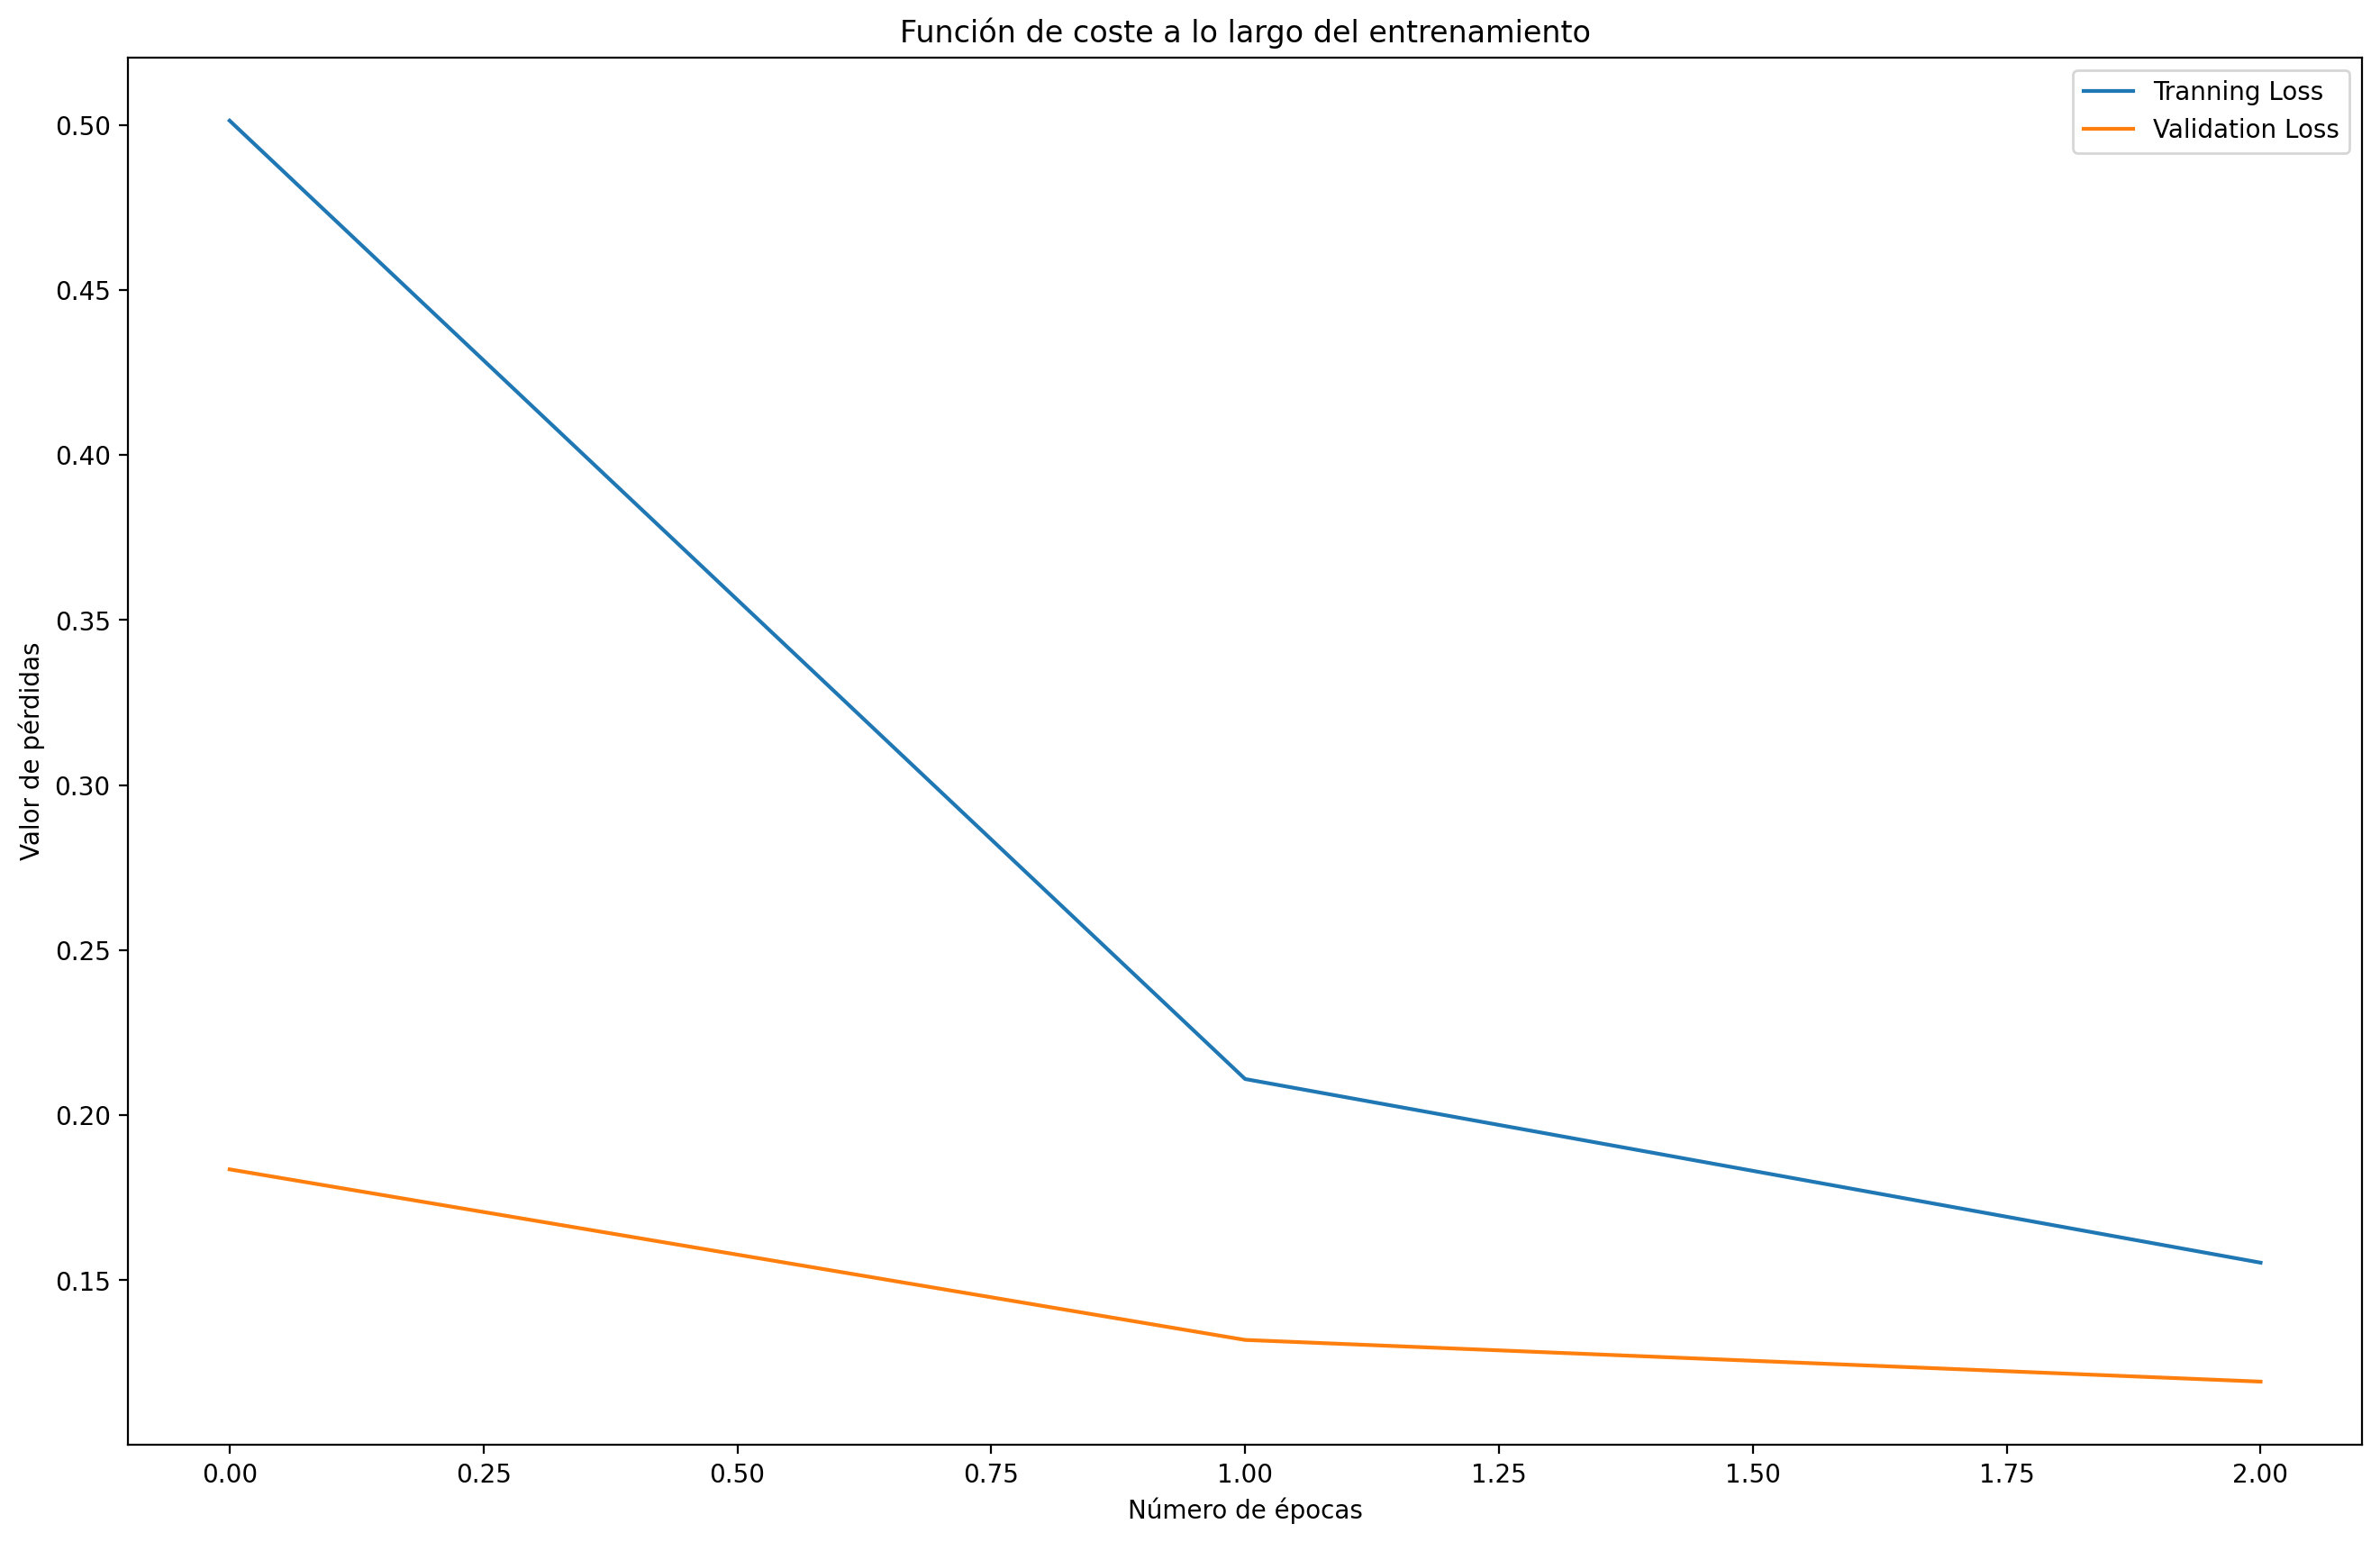

In [32]:
# Analizamos la función de coste de entrenamiento y de validación

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(my_MLP_drop.loss_during_training,label='Tranning Loss')
ax.plot(my_MLP_drop.valid_loss_during_training,label='Validation Loss')
ax.set_title('Función de coste a lo largo del entrenamiento')
ax.set_xlabel('Número de épocas')
ax.set_ylabel('Valor de pérdidas')
ax.legend()

Vemos como aplicando el dropout esta vez logramos mantener con tendencia decreciente la función de coste para el conjunto de validación. Esto es indicativo de que el modelo no ha sobreaprendido y es capaz de generalizar correctamente.

## Activation Maximization

Once our network has been trained, the goal is to find which features at the input of the network (pixels in our case) are more important for the classifier to decide one class or another at the output. That is, choose between one digit or another at the output. 

The steps we follow are the following:

- We fix the parameters that we have just trained.

- We define a new set of trainable parameters that will emulate the input of the network and we will opbtimize to have a high confidence in a specific digit.

We implement the first step with the following code:

In [33]:
for param in my_MLP_drop.parameters(): #my_MLP_drop is the name of your neural network!
    param.requires_grad = False

> **Exercise:** Complete the following code, in which we define the optimization problem to find the image at the input of the network that provides a given confidence in a given digit

In [34]:
class Optimize_NN_Input(nn.Module):

    def __init__(self,NN_trained,lr,img0): 
      
        # NN_trained is the trained network, as argument

        # img0 is a radomn initialization for the input image
        
        super().__init__()
        
        # Self.input --> Image to be optimized

        self.input = nn.Parameter(img0.reshape([1,-1]),requires_grad = True) # Introducimos una imagen puesta de forma aleatoria (tendrá forma de ruido)

        self.NN_trained = NN_trained # Introducimos la red entrenada

        self.lr = lr
        
        # We use mean squared error to minimize the difference between the desired probability and the 
        # obtained for self.input to input

        self.criterion = nn.MSELoss() 

        self.optim = optim.Adam(self.parameters(), self.lr)

        self.loss_during_training = []

    def forward(self):

        # In the forward method we only evaluate the log-probabilities given self.input!

        logprobs = self.NN_trained.forward(self.input) # Establecemos la salida a partir del input (la imágen con ruido)

        return logprobs

    def trainloop(self,category,true_prob,sgd_iter):

        # Category is the digit we are going to look at

        # true_prob is the desired probability, which we pass to logarithm
        
        true_log_prob = torch.log(true_prob) # Probabilidad esperada a la salida de la red

        # sgd_iter is the number of iterations
        
        for i in range(sgd_iter):

            # Reset the gradients
            #YOUR CODE HERE
            self.optim.zero_grad()
 
            
            # Compute the network output
            #YOUR CODE HERE
            logprobs = self.forward()
            
            # We calculate the difference between the desired probability (true_log_prob) and the obtained one
            # for the digit
            
            loss = self.criterion(logprobs[0,category].view(true_log_prob.shape),true_log_prob) # Hacemos una estimación de la pérdida comparando la probabilidad deseada con la obtenida
  

            self.loss_during_training.append(loss)

            # Compute gradients
            #YOUR CODE HERE
            loss.backward()
          
            # Optimize
            #YOUR CODE HERE
            self.optim.step()

Let's instanciate an object of the previous class for a random initialization (independent Gaussian distribution with mean zero and standard deviation 0.01)

In [35]:
opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(28,28)*0.01)

> **Exercise:** Obtain the probability distribution at the output of the classifier for the chosen initialization. Remember that the classifier uses a `logsoftmax` on output. Discuss the result.

In [36]:
#YOUR CODE HERE

logprobs = opt_input.forward() # Estudiamos la probabilidad que estima nuestra red 

print('Probabilidades estimadas para cada clase: ' + str(logprobs))

top_p, top_class = logprobs.topk(1, dim=1) # Topk toma, de las 10 probabilidades estimadas para cada clase, la más grande

print('')
print('Mayor probabilidad estimada: ' + str(top_p[0][0])) # Probabilidad estimada mayor
print('Clase a la que pertenece dicha probabilidad: ' + str(top_class[0][0])) # Clase que pertenece esa probabilidad estimada con mayor valor

Probabilidades estimadas para cada clase: tensor([[-2.7514, -2.6493, -3.0402, -2.5272, -2.0490, -1.7843, -2.6524, -1.9274,
         -2.5568, -1.9146]], grad_fn=<LogSoftmaxBackward0>)

Mayor probabilidad estimada: tensor(-1.7843, grad_fn=<SelectBackward0>)
Clase a la que pertenece dicha probabilidad: tensor(5)


Al utilizar la función de activación a la salida "logsoftmax", las probabilidades se devuelven en forma logarítmica, por lo que en vez de entre 0 y 1, tendrán valores negativos. Lo que está pasando aquí es que, dada la imagen con ruido, mi red ha estimado que pertenece a la clase 5.

> **Exercise:**: Optimize the input representation for 50 iterations to obtain 90% confidence in the digit 3. Plot the loss function.

In [37]:
#YOUR CODE HERE
opt_input.trainloop(category = 3 ,true_prob = torch.tensor(0.8),sgd_iter=50)

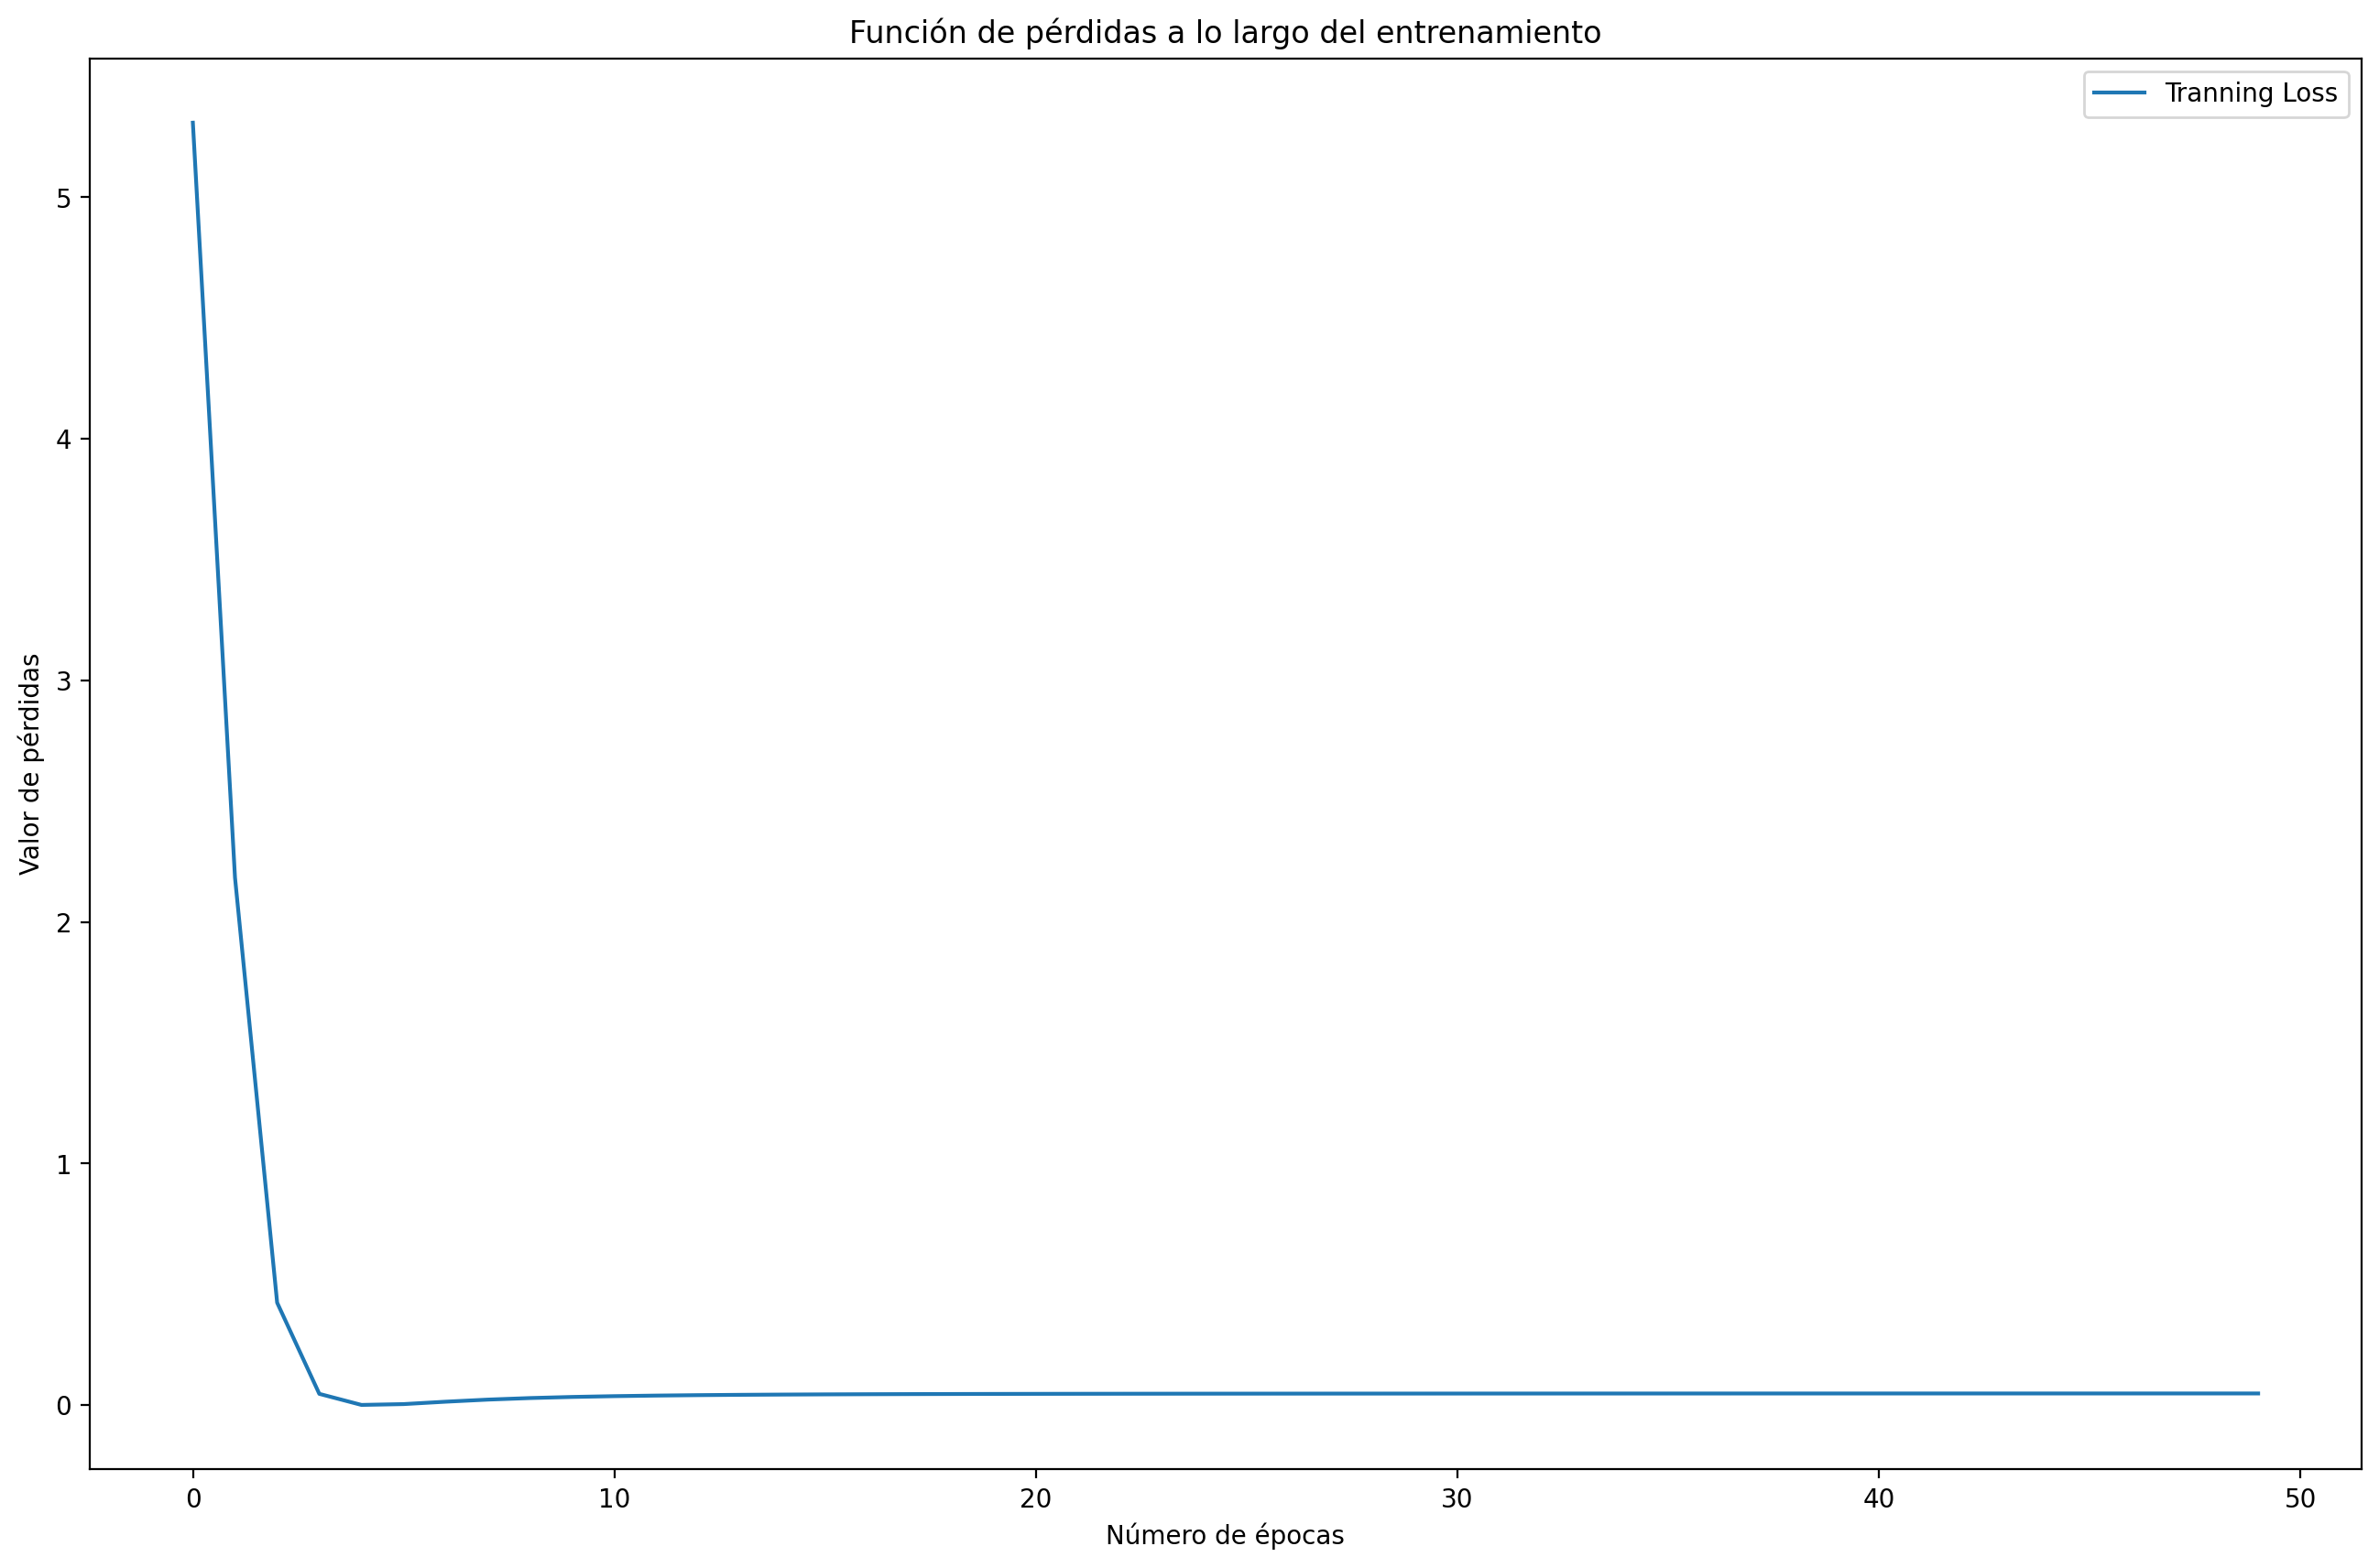

In [38]:
loss_training = []

for i in range (len(opt_input.loss_during_training)):
    loss_training.append(opt_input.loss_during_training[i].item())

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(loss_training,label='Tranning Loss')
ax.set_title('Función de pérdidas a lo largo del entrenamiento')
ax.set_xlabel('Número de épocas')
ax.set_ylabel('Valor de pérdidas')
ax.legend()

Podemos observar que hemos reducido de manera significativa la función de pérdidas, logrando así la precisión que buscamos.

> **Exercise:** Compare the probabilities at the output of the classifier before and after optimizing at the input

In [42]:
#YOUR CODE HERE

print('Mayor probabilidad estimada sin optimizar: ' + str(top_p[0][0])) # Probabilidad estimada mayor
print('Clase a la que pertenece dicha probabilidad: ' + str(top_class[0][0])) # Clase que pertenece a esa probabilidad estimada con mayor valor

Mayor probabilidad estimada sin optimizar: tensor(-0.0032, grad_fn=<SelectBackward0>)
Clase a la que pertenece dicha probabilidad: tensor(3)


In [43]:
#YOUR CODE HERE
logprobs = opt_input.forward()
top_p, top_class = logprobs.topk(1, dim=1)

print('Mayor probabilidad estimada habiendo optimizado: ' + str(top_p[0][0])) # Probabilidad estimada mayor
print('Clase a la que pertenece dicha probabilidad: ' + str(top_class[0][0])) # Clase que pertenece a esa probabilidad estimada con mayor valor

Mayor probabilidad estimada habiendo optimizado: tensor(-0.0032, grad_fn=<SelectBackward0>)
Clase a la que pertenece dicha probabilidad: tensor(3)


Antes de optimizar teníamos a la entrada una imagen con ruido y la mayor probabilidad se encontraba en la clase 5. Tras realizar una optimización enfocada a la clase 3 (donde en cada iteración modificamos la imagen de entrada de manera que se parezca a dicho valor), observamos como la red predice que pertence a la clase 3 con una probabilidad muy elevada.

> **Exercise:** Display the optimized input image. Does it roughly match the expected digit? Discuss the results.

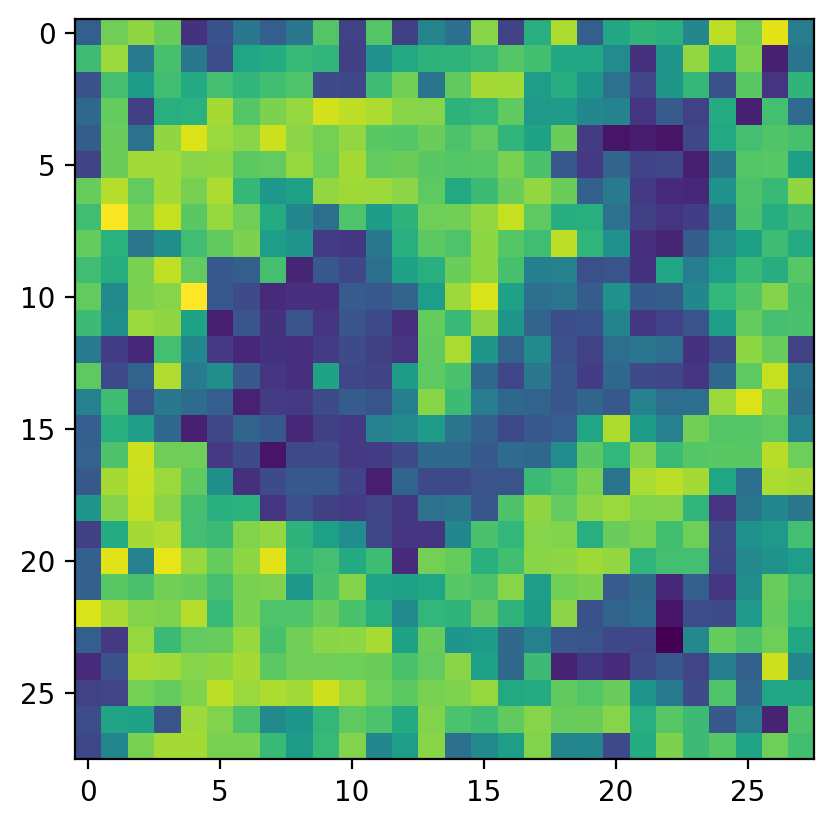

In [44]:
#YOUR CODE HERE
plt.imshow(opt_input.input.detach().numpy().reshape([28,28]))

Analizando la imagen podemos ver rasgos que podrían dar a entender que es el número 3. Sin embargo, no somos capaces de diferenciarlo con gran claridad. Esto es debido a que no hemos utilizado un número elevado de iteraciones por lo que la imagen no ha podido desarrollarse por completo. A pesar de no ser del todo reconocible para nosotros, la red si ha sido capaz de encontrar las características clave de dicho valor y así elevar su precisión en la predicción.

> **Exercise:** Repeat the results for all digits and discuss those results.

<Figure size 640x480 with 0 Axes>

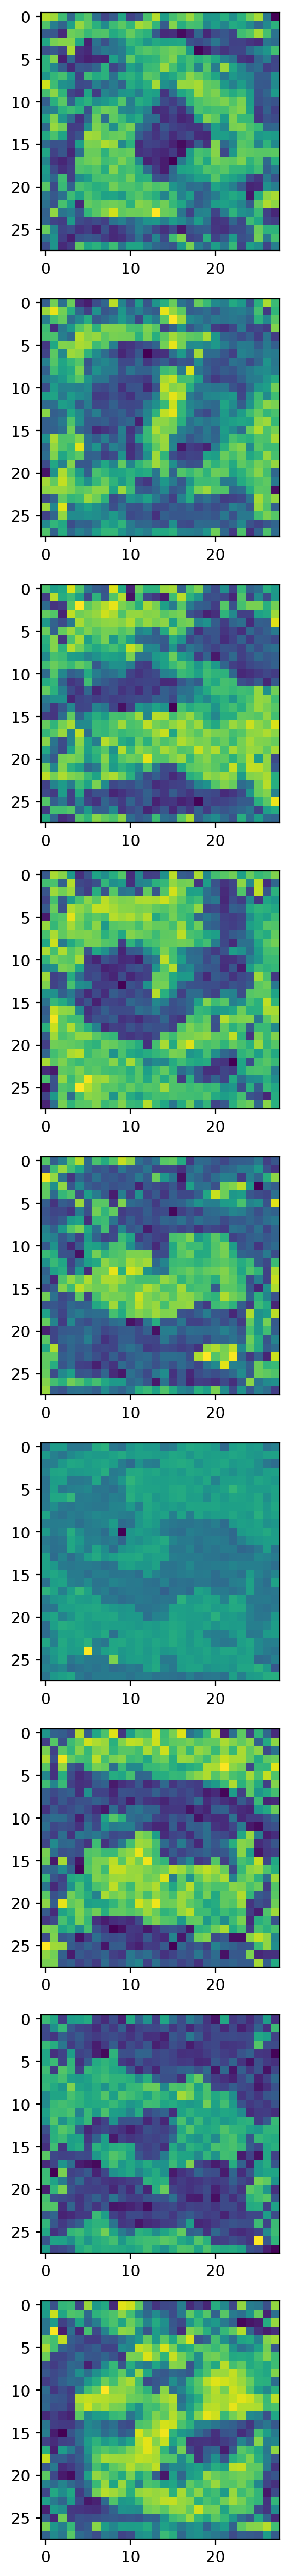

In [52]:
#YOUR CODE HERE
plt.figure()
f, axarr = plt.subplots(9,1, figsize = (30,30)) 

for i in range(9):
    opt_input = Optimize_NN_Input(NN_trained=my_MLP_drop,lr=5e-3,img0=torch.randn(28,28)*0.01)
    opt_input.trainloop(category = i ,true_prob = torch.tensor(0.8),sgd_iter=50)
    axarr[i].imshow(opt_input.input.detach().numpy().reshape([28,28]))
    

Al igual que ha ocurrido con la clase 3 anteriormente, con el número de iteraciones reducido no somos capaces de reconocer claramente los números en las imágenes. A pesar de ello, el modelo sí va a ser capaz de reconocer cada clase como hemos podido comprobar.